
# Looking Into the Iowa Sales 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
from dateutil.parser import parse
plt.style.use('ggplot')
% matplotlib inline

# Getting started

#Once you've chosen your scenario, download the data from the Iowa website in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

/Users/Scott/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Problem Statement 

I want to find the best independent variables I can utilize to predict current and future Liquor Sales for the state of Iowa in regards to Cities. 


# Iowa Liquor DataSet

Once you've chosen your scenario, download the data from the Iowa website in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [2]:
df = pd.read_csv('/Users/Scott/Documents/DSI6/Repo /Project 2/all_liquor_data.csv', low_memory=False)
#df = pd.read_csv('/Users/Scott/Documents/DSI 6 /Repo /Project 2/Iowa_Liquor_sales_sample_10pct.csv')
df['Zip Code'] = df['Zip Code'].astype(str)

In [3]:
df = df.rename(columns={'Zip Code': 'Zip', 'Item Description': 'Item Desc', 'Bottle Volume (ml)':'Bottle ml', 'State Bottle Cost':'btl cost','State Bottle Retail':'retail','Bottles Sold':'btl sold','Sale (Dollars)':'sold amt','Volume Sold (Liters)':'vol sold lt','Volume Sold (Gallons)':'vol sold gal'})

In [4]:
df.Date = pd.to_datetime(df.Date)

In [5]:
df.City = df.City.str.title()

In [6]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [7]:
df['sold amt'] = df['sold amt'].apply(lambda x: x.replace('$', ''))
df['btl cost'] = df['btl cost'].apply(lambda x: x.replace('$', ''))
df['retail'] = df['retail'].apply(lambda x: x.replace('$', ''))
#Getting rid of the dollar signs here so that it is easier to query columns 

In [8]:
df['sold amt'] = df['sold amt'].astype(float)
df['btl cost'] = df['btl cost'].astype(float)
df['retail'] = df['retail'].astype(float)
#Changing the type to float so that I could utilize math functions such as mean and sum

In [9]:
df = df.dropna()
# Here because we have so much data I am dropping all the null values, to make the analysis much easier. 

In [10]:
df = df[['Store Number','County','City','Category Name','retail','btl sold','sold amt','year','month']]

# #Population Data



In [12]:
City_Pop= pd.read_csv('/Users/Scott/Documents/DSI6/Repo /Project 2/Iowa_Pop.csv')

In [13]:
City_Pop.columns

Index(['GEO.id', 'GEO.id2', 'GEO.display-label', 'HD01_VD01'], dtype='object')

In [14]:
City_Pop = City_Pop[['GEO.display-label','HD01_VD01']]

In [15]:
City_Pop = City_Pop.drop(0)

In [16]:
City_Pop = City_Pop.rename(columns = {'GEO.display-label':'City','HD01_VD01':'city_population'})

In [17]:
City_Pop.City = City_Pop.City.apply(lambda x: x.replace(' city, Iowa',''))
#Getting rid of the spaces that causing issues 

In [18]:
City_Pop.City = City_Pop.City.apply(lambda x: x.replace(' CDP, Iowa',''))

# #Medium Income Data 



In [20]:
med_inc_iowa = pd.read_csv('/Users/Scott/Documents/DSI6/Repo /Project 2/iowa_income.csv')
med_inc_iowa = med_inc_iowa.rename(columns = {'GEO.display-label':'City','HC01_EST_VC02':'med_income'})
med_inc_iowa = med_inc_iowa[['City','med_income']]
med_inc_iowa = med_inc_iowa.drop(0)
med_inc_iowa = med_inc_iowa[med_inc_iowa.med_income != '(X)']
med_inc_iowa.City = med_inc_iowa.City.apply(lambda x: x.replace(' city, Iowa',''))
#Getting rid of the extra spaces 

# #Merging the Data



In [21]:
merg1 = pd.merge(df,City_Pop, on='City', how='left')

In [22]:
alc_info = pd.merge(merg1,med_inc_iowa, on='City', how='left')
alc_info.shape

(2692602, 11)

In [23]:
alc_info = alc_info.dropna()

In [24]:
alc_info.city_population = alc_info.city_population.astype(int)
alc_info.med_income = alc_info.med_income.astype(int)

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [25]:
alc_info.groupby(['City','city_population'])['btl sold','sold amt'].sum().reset_index().sort_values('city_population', ascending = False).head()
# Grouping by City and City Population to inspect the data

,City,city_population,btl sold,sold amt
88,Des Moines,208020,3449619,4.422948e+07
50,Cedar Rapids,128829,1897734,2.428958e+07
79,Davenport,101863,1520121,1.732320e+07
299,Sioux City,82792,898635,1.183258e+07
168,Iowa City,71832,962162,1.276243e+07


### Does the CITY affect Bottle sales and amount sold in dollar?

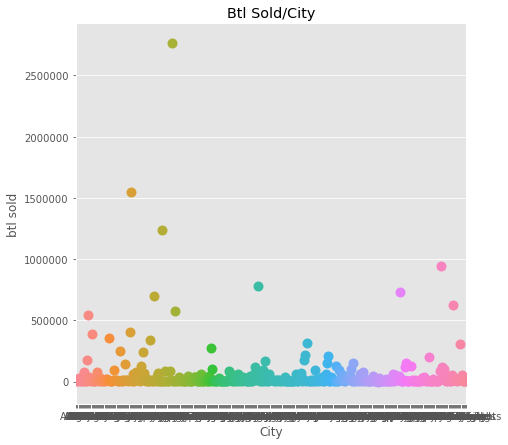

In [26]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (7,7)

data_2015 = alc_info[alc_info['year'] == 2015]
data_2016 = alc_info[alc_info['year'] == 2016]

#city_mean1 = data_2015.groupby(['City'])['btl sold'].sum().loc[lambda x: x>150000].reset_index()
city_mean1 = data_2015.groupby(['City'])['btl sold'].sum().loc[lambda x: x>0].reset_index()
sns.stripplot(x="City", y="btl sold", data = city_mean1, size=10)
plt.title('Btl Sold/City');


#It does not really appear like there is a direct correlation between cities and bottles sold. There are definitely 
#some cities that are sold to vastly more than others. Des Moines for example purchases a lot more than the others as
#it is the capital of Iowa. The data for the amount paid by the cities is similar to this. 

### Does the Month affect Bottle sales and amount sold in dollar?

In [ ]:
alc_2015 = alc_info[alc_info.year == 2015]
plt.title("Sold Amount Depending On Month")
sns.regplot('month','sold amt', data=alc_2015)
#It appears as though month does not have too much to do with bars purchasing bottles from the state 
#It seems like October and November have outliers, but it would be hard to infer how much they really make a difference

### Does the Population affect Bottle sales and amount sold in dollar?

In [ ]:
#pop_alc = data_2015.groupby(['iowa_population'])['btl sold'].sum().loc[lambda x: x>70000].reset_index()
pop_trend = data_2015[data_2015.city_population >10000]
pop_alc = pop_trend.groupby(['City','city_population'])['btl sold'].sum().reset_index()
sns.stripplot(x="city_population", y="btl sold", data = pop_alc, size = 8)
plt.title('Btl Sold/Population');

### Does the Salary affect Bottle sales and amount sold in dollar?

In [ ]:
import matplotlib.ticker as ticker

sns.factorplot('med_income','btl sold', data=salary_alc, size = 8)
plt.title('Bottles Sold/ Medium City Salary ')
plt.show()
#I wanted this graph to show that being rich doesn't mean they buy the most alochal, but sadly there are more medium 
# income earners than rich people so it makes sense that they would have the most sales in bottles. 

In [ ]:
city_to_store = alc_info.groupby(['City','city_population'])['Store Number'].count().reset_index()
city_to_store['ratio'] = (city_to_store['Store Number']/city_to_store['city_population'])
city_to_store.sort_values('ratio', ascending = False)
#Looking into the ratio of stores per population. 

# Mining the data

In [ ]:
data_2015_city = pd.get_dummies(data_2015, columns = ['City'], drop_first = True)

In [ ]:
data_2015_city = data_2015_city.drop(['Store Number','County','Category Name','retail','btl sold','sold amt','year','month','city_population','med_income'], axis = 1)

In [ ]:
targets = pd.DataFrame(data_2015['sold amt'], columns=['sold amt'])
import statsmodels.api as sm 
x = data_2015_city
y = targets

In [ ]:
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()
# I am telling this model to predict Y(total sold amount) based off of the city it was bought from. The R-squared 
#Value is extremely low and this does not appear to be a very good model to predict total sales off of locatoin 

In [ ]:
plt.scatter(predictions, y, s=30, c='r', zorder=10)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values Total Sales per Store/but this could be wrong')
plt.show()
print('MSE:', model.mse_model)

# Model based off of price per bottle 

In [ ]:
targets = pd.DataFrame(data_2015['sold amt'], columns=['sold amt'])
import statsmodels.api as sm 
x = data_2015['retail']
y = targets
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

In [ ]:
plt.scatter(predictions, y, s=30, c='r', zorder=10)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values Total Sales per Store')
plt.show()
print('MSE:', model.mse_model)
# As the R-squared Value is very low it shows how this was not a very successful estimate regarding determing total sales
#off of Price per bottle or the retail price. The graph is also not linear which makes sense why we have such a low 
#R squared value 


# Model based off of btl sold 

In [ ]:
targets = pd.DataFrame(data_2015['sold amt'], columns=['sold amt'])
import statsmodels.api as sm 
x = data_2015['btl sold']
y = targets
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()

In [ ]:
plt.scatter(predictions, y, s=30, c='r', zorder=10)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values Total Sales per Store')
plt.show()
print('MSE:', model.mse_model)

#The Rsquared value is higher for the total bottles sold, which makes sense as bottles sold increase so would the 
# the amount the state receives from the store. Its not a hundred percent as there are different botttle prices which 
#this model isn't taking into account 

# New Better Model 

In [ ]:
data_2015_month = pd.get_dummies(data_2015, columns = ['month'], drop_first = True)
data_2015_macro = data_2015_month.drop(['Store Number','County','Category Name','sold amt','year','City'], axis = 1)


In [ ]:
data_2015_macro.head()

In [ ]:
targets = pd.DataFrame(data_2015['sold amt'], columns=['sold amt'])
import statsmodels.api as sm 
x = data_2015_macro
y = targets
model = sm.OLS(y,x).fit()
predictions = model.predict(x)
model.summary()


In [ ]:
data_2015['Predictions'] = predictions

In [ ]:
plt.scatter(predictions, y, s=30, c='r', zorder=10)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values Total Sales per Store')
plt.show()
print('MSE:', model.mse_model)

# Testing: Cross Validation with 2015 data and then with 2016 data

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
print(model.score(X_test, y_test))

In [ ]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

## 2016 Data using the same model

In [ ]:
data_2016_month = pd.get_dummies(data_2016, columns = ['month'], drop_first = True)
data_2016_macro = data_2016_month.drop(['Store Number','County','Category Name','sold amt','year','City'], axis = 1)

targets = pd.DataFrame(data_2016['sold amt'], columns=['sold amt'])
import statsmodels.api as sm 
x = data_2016_macro
y = targets
model = sm.OLS(y,x).fit()
predictions = model.predict(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
print(model.score(X_test, y_test))
#Sadly the score went down almost 10 percent comapred to the r-squared on the previous model. 

In [ ]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

# Bias Variance Trade Off

As I made my final model less complicated by not including a dummy variable for all the cities, I decreased the Variance by not making it too complicated. However, by doing so my bias increased. I wouldn't say it increased that much, just because I still had a decent amount of independenct variables I was using to predict my depent variable total liquor sales. 

# Table of the best Performing Stores and the Predictions 

In [ ]:
data_2015.groupby(['City','Store Number'])['sold amt','Predictions','city_population'].sum().sort_values('sold amt', ascending = False).head()

In [ ]:
city_to_store = data_2015.groupby(['City','city_population'])['Store Number'].count().reset_index()

In [ ]:
city_to_store['ratio'] = (city_to_store['city_population']/city_to_store['Store Number'])
city_to_store.sort_values('ratio', ascending = False)

# Executive Summary


Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

I understand you want to buy liquor stores in Iowa and of course the perfect location is important. After research on our end we did not find the medium household income of a city or seasonality(months of the year) to be that important toward predicting future sales. Our numbers did show that with the rise of population, one would see a rise in sales for liquor in that city. Although this may not seem very helpful, it can be utilized toward your advantage. If we know that a cities medium income and seasonality does not play that big of a role and that population size just plays a normal role in prediction total sales, we can start focusing our attention on other matters. Now that we have gotten the macro identifiers covered, I would suggest picking a location were the micro differences could start affecting liquor sales. For instance the fixed costs, water, electirc and salaries of employees. Our company could look further into identifying the cheapest rent for the biggest value of return. As city location and seasonality do not play a major role, you can also decide one which city culture maybe fits your vibe. 